# Referencia a la implementación

https://towardsdatascience.com/an-efficient-implementation-of-dbscan-on-pyspark-3e2be646f57d/

In [1]:
!python --version

Python 3.9.21


In [2]:
import numpy as np
from scipy.spatial import distance

In [3]:
import pyspark.sql.functions as sql_f
from pyspark.sql import SparkSession

cores = 8

spark = (
    SparkSession.builder.master(f"local[{cores}]")
    .appName(f"DBSCAN paralelo con {cores} particiones")
    .config("spark.driver.memory", "16g")
    .config("spark.executor.memory", "16g")
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12")
    .getOrCreate()
)
sc = spark.sparkContext
sc.setCheckpointDir("/tmp/graphframes-checkpoints") 

Exception in thread "main" java.lang.ExceptionInInitializerError
	at org.apache.spark.unsafe.array.ByteArrayMethods.<clinit>(ByteArrayMethods.java:54)
	at org.apache.spark.internal.config.package$.<init>(package.scala:1144)
	at org.apache.spark.internal.config.package$.<clinit>(package.scala)
	at org.apache.spark.deploy.SparkSubmitArguments.$anonfun$loadEnvironmentArguments$3(SparkSubmitArguments.scala:157)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.deploy.SparkSubmitArguments.loadEnvironmentArguments(SparkSubmitArguments.scala:157)
	at org.apache.spark.deploy.SparkSubmitArguments.<init>(SparkSubmitArguments.scala:115)
	at org.apache.spark.deploy.SparkSubmit$$anon$2$$anon$3.<init>(SparkSubmit.scala:1026)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.parseArguments(SparkSubmit.scala:1026)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:85)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1043)
	at org.apache.spark.deploy

RuntimeError: Java gateway process exited before sending its port number

In [24]:
spark.version

'3.2.2'

In [7]:
## Prueba mínima de GraphFrames
from graphframes import GraphFrame

vertices = spark.createDataFrame([("a",), ("b",), ("c",)], ["id"])
edges = spark.createDataFrame([("a", "b"), ("b", "c")], ["src", "dst"])
g = GraphFrame(vertices, edges)

g.connectedComponents().show()

+---+-------------+
| id|    component|
+---+-------------+
|  a|1047972020224|
|  b|1047972020224|
|  c|1047972020224|
+---+-------------+



# Carga de datos

In [8]:
df = spark.read.format('csv').option('header', 'true').load('spotify_songs.csv').repartition(10)

In [9]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

numeric_cols = []

for column in df.columns:
    # Intenta convertir la columna a Double
    converted = df.withColumn(column + "_tmp", col(column).cast(DoubleType()))
    
    # Verifica si hay valores que eran válidos antes y ahora son null (falló la conversión)
    null_count = converted.filter(
        col(column).isNotNull() & col(column + "_tmp").isNull()
    ).count()
    
    if null_count == 0:
        numeric_cols.append(column)

# Aplica la conversión solo a las columnas válidas
for col_name in numeric_cols:
    df = df.withColumn(col_name, col(col_name).cast(DoubleType()))

In [10]:
df.schema

StructType(List(StructField(track_id,StringType,true),StructField(track_name,StringType,true),StructField(track_artist,StringType,true),StructField(track_popularity,DoubleType,true),StructField(track_album_id,StringType,true),StructField(track_album_name,StringType,true),StructField(track_album_release_date,StringType,true),StructField(playlist_name,StringType,true),StructField(playlist_id,StringType,true),StructField(playlist_genre,StringType,true),StructField(playlist_subgenre,StringType,true),StructField(danceability,StringType,true),StructField(energy,StringType,true),StructField(key,StringType,true),StructField(loudness,StringType,true),StructField(mode,StringType,true),StructField(speechiness,DoubleType,true),StructField(acousticness,DoubleType,true),StructField(instrumentalness,DoubleType,true),StructField(liveness,DoubleType,true),StructField(valence,DoubleType,true),StructField(tempo,DoubleType,true),StructField(duration_ms,DoubleType,true)))

In [11]:
from pyspark.sql.types import NumericType

# Supongamos que tienes un DataFrame llamado df
numeric_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType) or field == 'track_id']

# Selecciona solo las columnas numéricas
df_numeric = df.select(*numeric_cols)

In [12]:
df_numeric.show()

+----------------+-----------+------------+----------------+--------+-------+-------+-----------+
|track_popularity|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|
+----------------+-----------+------------+----------------+--------+-------+-------+-----------+
|            46.0|     0.0802|       0.144|         5.11E-4|  0.0369|  0.682| 92.992|   194332.0|
|             0.0|     0.0358|        0.94|           0.022|   0.071| 0.0698|147.179|   377747.0|
|            37.0|      0.209|       0.247|             0.0|   0.129|  0.687|146.099|   323960.0|
|            31.0|       0.16|      0.0204|         9.67E-6|   0.136|  0.839|139.804|   187260.0|
|            80.0|      0.177|     0.00836|         0.00233|   0.613|  0.772|138.559|   222640.0|
|            65.0|     0.0388|       0.115|         4.23E-5|   0.071|  0.449| 99.233|   345840.0|
|            69.0|     0.0525|     5.36E-5|         6.54E-6|   0.707|  0.372| 155.01|   242680.0|
|            78.0|  

# Código de DBScan original

In [19]:
from pyspark.sql import Row
import math
from graphframes import *
from itertools import combinations


def __distance_from_pivot(pivot, dist, epsilon, operations):
    def distance(x):
        pivot_dist = dist(x.value, pivot)
        if operations is not None:
            operations.add()
        partition_index = math.floor(pivot_dist / epsilon)
        rows = [Row(id=x.id, value=x.value, pivot_dist=dist(x.value, pivot))]
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out
    return distance


def __scan(epsilon, dist, operations):
    def scan(x):
        # out dictionary would have point id as key and a set of point ids who are within epsilon distance to
        # key point id. value is basically its neighbors
        out = {}
        # 0th index of x is partition_index
        # 1st index of x is data points
        partition_data = x[1]
        partition_len = len(partition_data)
        for i in range(partition_len):
            for j in range(i + 1, partition_len):
                if operations is not None:
                    operations.add()
                if dist(partition_data[i].value, partition_data[j].value) < epsilon:
                    # both i and j are within epsilon distance to each other
                    if partition_data[i].id in out:
                        out[partition_data[i].id].add(partition_data[j].id)
                    else:
                        out[partition_data[i].id] = set([partition_data[j].id])
                    if partition_data[j].id in out:
                        out[partition_data[j].id].add(partition_data[i].id)
                    else:
                        out[partition_data[j].id] = set([partition_data[i].id])
        # returns point and its neighbor as tuple
        return [Row(item[0], item[1]) for item in out.items()]

    return scan


def __label(min_pts):
    def label(x):
        if len(x[1]) + 1 >= min_pts:
            # use id as cluster label
            cluster_label = x[0]
            # return True for core point
            out = [(x[0], [(cluster_label, True)])]
            for idx in x[1]:
                # return False for base point
                out.append((idx, [(cluster_label, False)]))
            return out
        return []

    return label


def __combine_labels(x):
    # 0th element is the id of point
    # 1st element is the list of tuples with cluster and core point label
    point = x[0]
    core_point = False
    cluster_labels = x[1]
    clusters = []
    for (label, point_type) in cluster_labels:
        if point_type is True:
            core_point = True
        clusters.append(label)
    # if core point keep all cluster otherwise only one
    return point, clusters if core_point is True else [clusters[0]], core_point


def process(spark, df, epsilon, min_pts, dist, dim, checkpoint_dir, operations=None):
    """
    Process given dataframe with DBSCAN parameters
    :param spark: spark session
    :param df: input data frame where each row has id and value keys
    :param epsilon: DBSCAN parameter for distance
    :param min_pts: DBSCAN parameter for minimum points to define core point
    :param dist: method to calculate distance. Only distance metric is supported.
    :param dim: number of dimension of input data
    :param checkpoint_dir: checkpoint path as required by Graphframe
    :param operations: class for managing accumulator to calculate number of distance operations
    :return: A dataframe of point id, cluster component and boolean indicator for core point
    """
    zero = df.rdd.takeSample(False, 1)[0].value
    
    combine_cluster_rdd = df.rdd.\
        flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
        reduceByKey(lambda x, y: x + y).\
        flatMap(__scan(epsilon, dist, operations)). \
        reduceByKey(lambda x, y: x.union(y)).\
        flatMap(__label(min_pts)).\
        reduceByKey(lambda x, y: x + y).map(__combine_labels).cache()
    
    id_cluster_rdd = combine_cluster_rdd.\
        map(lambda x: Row(point=x[0], cluster_label=x[1][0], core_point=x[2]))
    try:
        id_cluster_df = id_cluster_rdd.toDF()
        vertices = combine_cluster_rdd.\
            flatMap(lambda x: [Row(id=item) for item in x[1]]).toDF().distinct()
        edges = combine_cluster_rdd. \
            flatMap(lambda x: [Row(src=item[0], dst=item[1])
                               for item in combinations(x[1], 2)]). \
            toDF().distinct()
        spark.sparkContext.setCheckpointDir(checkpoint_dir)
        g = GraphFrame(vertices, edges)
        connected_df = g.connectedComponents()
        id_cluster_df = id_cluster_df.\
            join(connected_df, connected_df.id == id_cluster_df.cluster_label). \
            select("point", "component", "core_point")
        return id_cluster_df
    except ValueError:
        return None


__all__ = [process]

# Código de DBScan con comentarios (debug)

In [14]:
from pyspark.sql import Row
import math
from graphframes import *
from itertools import combinations


def __distance_from_pivot(pivot, dist, epsilon, operations):
    def distance(x):
        pivot_dist = dist(x.value, pivot)
        if operations is not None:
            operations.add()
        partition_index = math.floor(pivot_dist / epsilon)
        rows = [Row(id=x.id, value=x.value, pivot_dist=pivot_dist)]
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out
    return distance


def __scan(epsilon, dist, operations):
    def scan(x):
        out = {}
        partition_data = x[1]
        partition_len = len(partition_data)
        for i in range(partition_len):
            for j in range(i + 1, partition_len):
                if operations is not None:
                    operations.add()
                if dist(partition_data[i].value, partition_data[j].value) < epsilon:
                    if partition_data[i].id in out:
                        out[partition_data[i].id].add(partition_data[j].id)
                    else:
                        out[partition_data[i].id] = set([partition_data[j].id])
                    if partition_data[j].id in out:
                        out[partition_data[j].id].add(partition_data[i].id)
                    else:
                        out[partition_data[j].id] = set([partition_data[i].id])
        result = [Row(id=item[0], neighbors=item[1]) for item in out.items()]
        return result
    return scan


def __label(min_pts):
    def label(x):
        if len(x[1]) + 1 >= min_pts:
            cluster_label = x[0]
            out = [(x[0], [(cluster_label, True)])]
            for idx in x[1]:
                out.append((idx, [(cluster_label, False)]))
            return out
        return []
    return label


def __combine_labels(x):
    point = x[0]
    core_point = False
    cluster_labels = x[1]
    clusters = []
    for (label, point_type) in cluster_labels:
        if point_type:
            core_point = True
        clusters.append(label)
    return point, clusters if core_point else [clusters[0]], core_point


def process(spark, df, epsilon, min_pts, dist, dim, checkpoint_dir, operations=None):
    zero = df.rdd.takeSample(False, 1)[0].value
    print(">> rdd sample:", df.rdd.take(5))
    print(">> Zero (pivot sample):", zero)

    rdd_1 = df.rdd.flatMap(__distance_from_pivot(zero, dist, epsilon, operations))
    print(">> rdd_1 sample:")
    print(rdd_1.take(1000))
    print("FIN")

    print('Null count', rdd_1.filter(col("value").isNull()).count())

    rdd_2 = rdd_1.reduceByKey(lambda x, y: x + y)
    print(">> rdd_2 sample:", rdd_2.take(1))

    rdd_3 = rdd_2.flatMap(__scan(epsilon, dist, operations))
    print(">> rdd_3 sample (neighbors):", rdd_3.take(5))

    rdd_4 = rdd_3.map(lambda x: (x.id, x.neighbors)).reduceByKey(lambda x, y: x.union(y))
    print(">> rdd_4 sample (merged neighbors):", rdd_4.take(5))

    rdd_5 = rdd_4.flatMap(__label(min_pts))
    print(">> rdd_5 sample (labeled):", rdd_5.take(5))

    rdd_6 = rdd_5.reduceByKey(lambda x, y: x + y)
    print(">> rdd_6 sample (labels grouped):", rdd_6.take(5))

    combine_cluster_rdd = rdd_6.map(__combine_labels).cache()
    print(">> combine_cluster_rdd sample (combined):", combine_cluster_rdd.take(5))

    id_cluster_rdd = combine_cluster_rdd.map(lambda x: Row(point=x[0], cluster_label=x[1][0], core_point=x[2]))
    print(">> id_cluster_rdd sample:", id_cluster_rdd.take(5))

    try:
        id_cluster_df = id_cluster_rdd.toDF()
        print(">> id_cluster_df schema:")
        id_cluster_df.printSchema()

        vertices = combine_cluster_rdd.flatMap(lambda x: [Row(id=item) for item in x[1]]).toDF().distinct()
        print(">> vertices preview:")
        vertices.show(5)

        edges = combine_cluster_rdd.flatMap(
            lambda x: [Row(src=item[0], dst=item[1]) for item in combinations(x[1], 2)]
        ).toDF().distinct()
        print(">> edges preview:")
        edges.show(5)

        spark.sparkContext.setCheckpointDir(checkpoint_dir)
        g = GraphFrame(vertices, edges)
        connected_df = g.connectedComponents()

        print(">> connected_df schema:")
        connected_df.printSchema()

        id_cluster_df = id_cluster_df.join(connected_df, connected_df.id == id_cluster_df.cluster_label). \
            select("point", "component", "core_point")

        print(">> Final result:")
        id_cluster_df.show(5)

        return id_cluster_df
    except ValueError as e:
        print(">> Error en conversión a DF o GraphFrame:", e)
        return None


In [15]:
# Carga rápida de datos
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

# Define las columnas que quieres incluir en cada lista
id_cols = ['track_id', 'track_name', 'track_artist']
value_cols = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'
]

# Casteo explícito a FloatType
df_casted = df
for col in value_cols:
    df_casted = df_casted.withColumn(col, F.col(col).cast(FloatType()))

# Crear las columnas de listas
df_transformed = df_casted.withColumn("id", F.monotonically_increasing_id()) \
                          .withColumn("value", F.array([F.col(c) for c in value_cols])) \
                          .select("id", "value")
                          #.withColumn("id", F.array([F.col(c) for c in id_cols])) \

In [16]:
df_transformed.printSchema()

root
 |-- id: long (nullable = false)
 |-- value: array (nullable = false)
 |    |-- element: float (containsNull = true)



In [17]:
df_transformed.columns.__len__()

2

In [20]:
# Ejecución del algoritmo
df_clusters = process(spark, df_transformed, 200000, 10, distance.euclidean, 12, "checkpoint")

25/04/22 20:08:10 ERROR Executor: Exception in task 7.0 in stage 306.0 (TID 5002)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 609, in process
    out_iter = func(split_index, iterator)
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/rdd.py", line 2918, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/rdd.py", line 2918, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/rdd.py", line 417, in func
    return f(iterator)


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 306.0 failed 1 times, most recent failure: Lost task 3.0 in stage 306.0 (TID 4998) (192.168.18.28 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 609, in process
    out_iter = func(split_index, iterator)
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/rdd.py", line 2918, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/rdd.py", line 2918, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/rdd.py", line 417, in func
    return f(iterator)
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/rdd.py", line 2146, in combineLocally
    merger.mergeValues(iterator)
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py", line 240, in mergeValues
    for k, v in iterator:
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_15502/2357631245.py", line 9, in distance
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/scipy/spatial/distance.py", line 597, in euclidean
    return minkowski(u, v, p=2, w=w)
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/scipy/spatial/distance.py", line 488, in minkowski
    u_v = u - v
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:556)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:762)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:744)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:509)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1211)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1491)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 609, in process
    out_iter = func(split_index, iterator)
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/rdd.py", line 2918, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/rdd.py", line 2918, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/rdd.py", line 417, in func
    return f(iterator)
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/rdd.py", line 2146, in combineLocally
    merger.mergeValues(iterator)
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py", line 240, in mergeValues
    for k, v in iterator:
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_15502/2357631245.py", line 9, in distance
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/scipy/spatial/distance.py", line 597, in euclidean
    return minkowski(u, v, p=2, w=w)
  File "/home/usuario/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/scipy/spatial/distance.py", line 488, in minkowski
    u_v = u - v
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:556)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:762)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:744)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:509)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1211)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1491)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


# Prueba 2 (Datos originales)

In [23]:
from sklearn.datasets import make_blobs
from pyspark.sql import types as T, SparkSession
from scipy.spatial import distance
from matplotlib import pyplot as plt
import math
from pyspark.sql import Row

ModuleNotFoundError: No module named 'matplotlib'

Text(0.5, 1.0, 'Data Points')

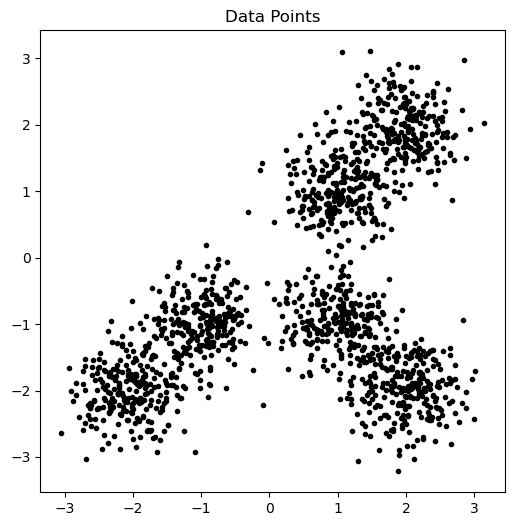

In [1]:
spark = SparkSession \
        .builder \
        .appName("DBSCAN") \
        .config('spark.driver.host', '127.0.0.1') \
        .getOrCreate()

centers = [[1, 1], [-1, -1], [1, -1], [2, 2], [-2, -2], [2, -2]]
X, labels_true = make_blobs(n_samples=1500, centers=centers, cluster_std=0.4, random_state=5)
plt.subplots(figsize=(6, 6))
plt.plot(X[:, 0], X[:, 1], 'o', markerfacecolor=[0, 0, 0, 1],
             markeredgecolor='k', markersize=3, scalex=1, scaley=1)
plt.title('Data Points')

#.config("spark.jars.packages", "graphframes:graphframes:0.6.0-spark3.5-s_2.12") \

In [4]:
data = [(i, [float(item) for item in X[i]]) for i in range(X.shape[0])]
schema = T.StructType([T.StructField("id", T.IntegerType(), False),
                               T.StructField("value", T.ArrayType(T.FloatType()), False)])
#please repartition appropriately                            
df = spark.createDataFrame(data, schema=schema).repartition(10)

In [7]:
def __distance_from_pivot(pivot, dist, epsilon, operations):
    def distance(x):
        pivot_dist = dist(x.value, pivot)
        if operations is not None:
            operations.add()
        partition_index = math.floor(pivot_dist / epsilon)
        rows = [Row(id=x.id, value=x.value, pivot_dist=dist(x.value, pivot))]
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out
    return distance

In [28]:
dim = 2
dist = distance.euclidean
epsilon = 0.1
operations = None
min_pts = 3

zero = [0] * dim
rdd1 = df.rdd.flatMap(__distance_from_pivot(zero, dist, epsilon, operations))
rdd1.take(1)

[(14,
  [Row(id=643, value=[1.209380865097046, -0.7132984399795532], pivot_dist=1.4040643650987454)])]

[(1, [Row(id='1kXPcN9OPdz7kPxc8HjFsY', value=[0.5210000276565552, 0.49399998784065247, 2.0, -9.819999694824219, 1.0, 0.027499999850988388, 0.14800000190734863, 0.0012100000167265534, 0.11299999803304672, 0.4699999988079071, 77.30500030517578, 217455.0], pivot_dist=22545.048376295916)])]


In [31]:
rdd2 = rdd1.reduceByKey(lambda x, y: x + y)
rdd2.collect()

[(20,
  [Row(id=441, value=[-1.5828876495361328, -1.171876311302185], pivot_dist=1.9694738891504093),
   Row(id=300, value=[-1.3546278476715088, -1.4445395469665527], pivot_dist=1.9803310603122595),
   Row(id=461, value=[1.3090280294418335, -1.619676947593689], pivot_dist=2.082524380753027),
   Row(id=632, value=[1.4486013650894165, -1.4582831859588623], pivot_dist=2.0554891790980685),
   Row(id=818, value=[1.4724321365356445, 1.2296756505966187], pivot_dist=1.918373947480819),
   Row(id=871, value=[1.3892204761505127, -1.5740100145339966], pivot_dist=2.0993906394973685),
   Row(id=1138, value=[-1.5781208276748657, -1.1095936298370361], pivot_dist=1.9291613126216618),
   Row(id=692, value=[1.2136300802230835, 1.6777312755584717], pivot_dist=2.070671438111161),
   Row(id=350, value=[-0.8636351227760315, -1.9102617502212524], pivot_dist=2.0964173200130585),
   Row(id=254, value=[1.0438439846038818, 1.6329925060272217], pivot_dist=1.938111139469245),
   Row(id=115, value=[1.66547465324401

In [63]:
def __scan(epsilon, dist, operations):
    def scan(x):
        # out dictionary would have point id as key and a set of point ids who 
        # are within epsilon distance to key point id. value is basically its neighbors
        out = {}
        # 0th index of x is partition_index
        # 1st index of x is data points
        partition_data = x[1]
        partition_len = len(partition_data)
        for i in range(partition_len):
            
            for j in range(i + 1, partition_len):
                if operations is not None:
                    operations.add()
                if dist(partition_data[i].value, partition_data[j].value) < epsilon:
                    # both i and j are within epsilon distance to each other
                    if partition_data[i].id in out:
                        out[partition_data[i].id].add(partition_data[j].id)
                    else:
                        out[partition_data[i].id] = set([partition_data[j].id])
                    if partition_data[j].id in out:
                        out[partition_data[j].id].add(partition_data[i].id)
                    else:
                        out[partition_data[j].id] = set([partition_data[i].id])
        # returns point and its neighbor as tuple
        return [Row(item[0], item[1]) for item in out.items()]

    return scan

In [66]:
df.rdd.flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
        reduceByKey(lambda x, y: x + y).flatMap(__scan(epsilon, dist, operations)). \
        reduceByKey(lambda x, y: x.union(y)) \
        .collect()

[(780, {300, 316, 631, 992, 1451}),
 (300, {316, 631, 780, 909, 1451}),
 (770, {115, 509, 543, 750}),
 (750, {509, 543, 740, 770, 1333, 1447}),
 (10, {441, 708, 1138, 1464}),
 (740, {509, 543, 750, 870, 1146, 1234, 1333, 1382, 1447}),
 (870, {509, 543, 740, 1146, 1234, 1333, 1382, 1447}),
 (590, {149, 1431}),
 (1100, {105}),
 (610, {16, 826, 891, 940, 1025}),
 (1440, {1047}),
 (700, {80, 256, 295, 355, 358, 481, 611, 1012, 1135, 1493}),
 (80, {43, 256, 295, 355, 358, 481, 603, 700, 1012, 1135, 1396, 1493}),
 (940, {225, 610, 703, 891, 894, 953, 1025, 1283}),
 (670, {244, 490, 827, 1203, 1443}),
 (490, {363, 670, 1203, 1219, 1378}),
 (920, {344, 555, 964, 1045, 1117, 1405}),
 (360, {20, 709, 1125}),
 (110, {322, 627, 1160, 1419}),
 (1160, {110, 322, 406, 627, 1419}),
 (1360, {202, 451, 739, 1213, 1427}),
 (250, {221, 682, 1347}),
 (1040, {294, 345, 389, 617, 753, 1163, 1238, 1392}),
 (580, {317, 627}),
 (570, {963, 1129, 1328}),
 (240, {249, 289, 979, 1099, 1223, 1401}),
 (210, {143, 85

In [69]:
def __combine_labels(x):
    # 0th element is the id of point
    # 1st element is the list of tuples with cluster and core point label
    point = x[0]
    core_point = False
    cluster_labels = x[1]
    clusters = []
    for (label, point_type) in cluster_labels:
        if point_type is True:
            core_point = True
        clusters.append(label)
    # if core point keep all cluster otherwise only one
    return point, clusters if core_point is True else [clusters[0]], core_point

In [72]:
df.rdd.flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
        reduceByKey(lambda x, y: x + y).flatMap(__scan(epsilon, dist, operations)). \
        reduceByKey(lambda x, y: x.union(y)).flatMap(__label(min_pts)).\
        reduceByKey(lambda x, y: x + y).map(__combine_labels).\
        collect()

[(780, [780, 300, 631, 1451, 992, 316], True),
 (300, [780, 300, 631, 1451, 316, 909], True),
 (770, [770, 750, 543, 115, 509], True),
 (750, [770, 750, 740, 543, 1333, 1447, 509], True),
 (740, [750, 740, 870, 1382, 543, 1333, 1234, 1146, 1447, 509], True),
 (10, [10, 441, 1464, 708, 1138], True),
 (870, [740, 870, 1382, 543, 1333, 1234, 1146, 1447, 509], True),
 (590, [590, 1431, 149], True),
 (610, [610, 940, 891, 1025, 16, 826], True),
 (940, [610, 940, 891, 1283, 703, 953, 894, 1025, 225], True),
 (700, [700, 80, 611, 481, 1012, 1493, 295, 1135, 355, 256, 358], True),
 (80,
  [700, 80, 481, 1012, 1493, 43, 603, 295, 1135, 355, 1396, 256, 358],
  True),
 (670, [670, 490, 1443, 1203, 244, 827], True),
 (490, [670, 490, 1203, 363, 1378, 1219], True),
 (920, [920, 344, 964, 1405, 1045, 555, 1117], True),
 (360, [360], True),
 (20, [360], False),
 (110, [110, 1160, 322, 627, 1419], True),
 (1160, [110, 1160, 322, 406, 627, 1419], True),
 (1360, [1360, 451, 202, 1213, 1427, 739], True),

In [73]:
from graphframes import *
combine_cluster_rdd = df.rdd.\
        flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
        reduceByKey(lambda x, y: x + y).\
        flatMap(__scan(epsilon, dist, operations)). \
        reduceByKey(lambda x, y: x.union(y)).\
        flatMap(__label(min_pts)).\
        reduceByKey(lambda x, y: x + y).map(__combine_labels).cache()
print(combine_cluster_rdd.take(5))

[(780, [780, 300, 631, 1451, 992, 316], True), (300, [780, 300, 631, 1451, 316, 909], True), (770, [770, 750, 543, 115, 509], True), (750, [770, 750, 740, 543, 1333, 1447, 509], True), (740, [750, 740, 870, 1382, 543, 1333, 1234, 1146, 1447, 509], True)]


In [74]:
vertices = combine_cluster_rdd.\
            flatMap(lambda x: [Row(id=item) for item in x[1]]).toDF().distinct()
edges = combine_cluster_rdd. \
            flatMap(lambda x: [Row(src=item[0], dst=item[1])
                               for item in combinations(x[1], 2)]). \
            toDF().distinct()
print(vertices.show(5))
print(edges.show(5))

+----+
|  id|
+----+
| 964|
|  26|
|  29|
|1360|
|1010|
+----+
only showing top 5 rows

None
+---+----+
|src| dst|
+---+----+
|280| 968|
|600|1352|
|293| 338|
|450| 646|
|476|1137|
+---+----+
only showing top 5 rows

None


In [86]:
g = GraphFrame(vertices, edges)
connected_df = g.connectedComponents()

Py4JJavaError: An error occurred while calling o934.loadClass.
: java.lang.ClassNotFoundException: org.graphframes.GraphFramePythonAPI
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:592)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:525)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=97fa435b-89c8-4b22-a4df-60f2ff3508a1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>